# Dataset exploration and preprocessing

In [1]:
#import packages


import time
import re
import logging
import warnings
import nltk
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from gensim.models import word2vec
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [2]:
nltk.download('popular')
warnings.filterwarnings('ignore')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

## Exploring the dataset

In [3]:
path_train_data = 'labeledTrainData.tsv'

df = pd.read_csv(path_train_data, delimiter = '\t')

In [4]:
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
#Size of the training dataset

df.shape

(25000, 3)

In [6]:
#Exemple d'une critique de film

print('Exemple d\'une critique de film :\n')
print(df['review'][0])
sent = df['sentiment'][0]
print(f'\nlabel de cette critique :{sent} \n\nRappel : 1 = positif, 0 = négatif')

Exemple d'une critique de film :

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual fea

In [7]:
print(len(df['review'][0]))

2302


In [8]:
df_copy = df.copy()

df_copy['lenght'] = df['review']

In [9]:
df_copy['lenght'] = df_copy['lenght'].apply(lambda x : len(x))
df_copy.head()

,id,sentiment,review,lenght
0,5814_8,1,With all this stuff going down at the moment w...,2302
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",946
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,2449
3,3630_4,0,It must be assumed that those who praised this...,2245
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,2231


In [10]:
#uniformisation des légendes matplotblib

font_title = {'color':  'steelblue',
        'weight': 'normal',
        'size': 16}

font_label = {'color':  'darkslategray',
        'weight': 'normal',
        'size': 12}

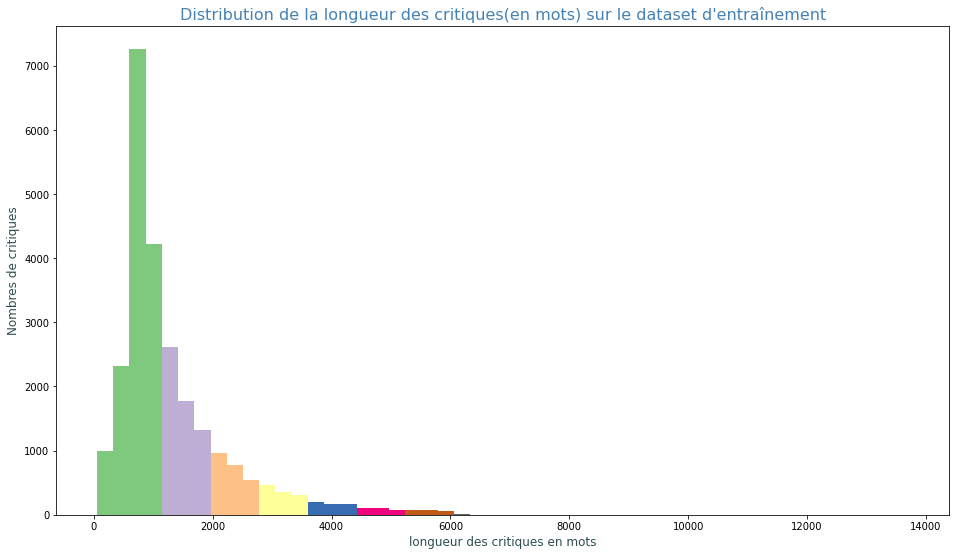

In [13]:
fig = plt.figure(1, figsize=(16, 9))

cm = plt.cm.get_cmap('Accent')

n, bins, patches = plt.hist(df_copy['lenght'],bins = 50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])


for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/25)) 
plt.title('Distribution de la longueur des critiques\
(en mots) sur le dataset d\'entraînement', 
          fontdict = font_title)

plt.xlabel('longueur des critiques en mots', fontdict = font_label)
plt.ylabel('Nombres de critiques', fontdict = font_label)

plt.show()



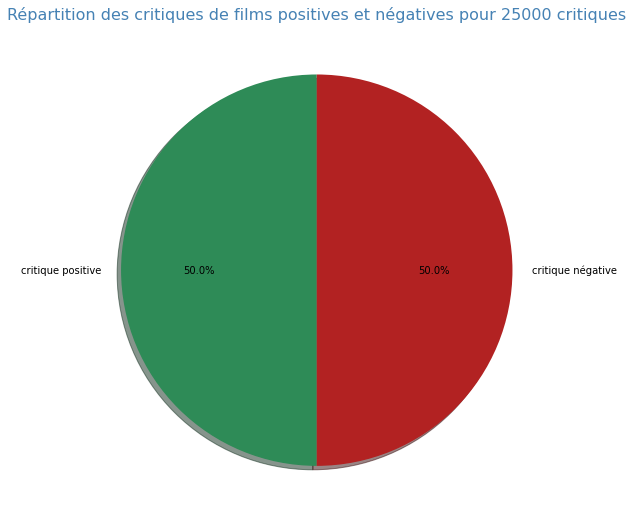

In [14]:
#Répartition des labels 
nb_donnees = 25000
x = [np.sum(df['sentiment']),nb_donnees - np.sum(df['sentiment'])]
labels = ['critique positive', 'critique négative' ]
colors = ['seagreen', 'firebrick']
plt.figure(1, figsize = (16,9))

plt.pie(x, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = colors)
plt.title(f'Répartition des critiques de films positives \
et négatives pour {nb_donnees} critiques', fontdict = font_title)
plt.show()

Text(0, 0.5, 'Densité')

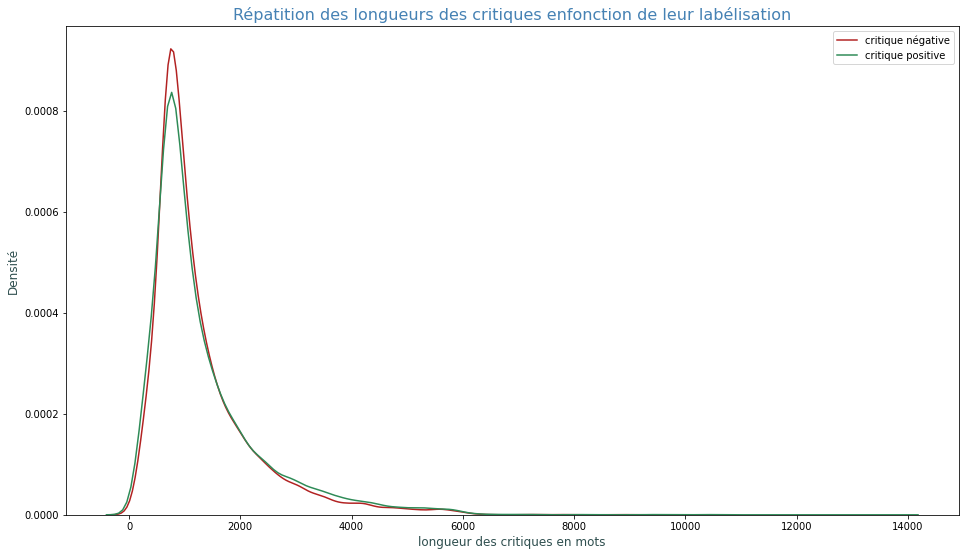

In [15]:
plt.figure(1, figsize=(16,9))

sns.kdeplot(df_copy[df_copy['sentiment']==0]['lenght'],color='firebrick')
sns.kdeplot(df_copy[df_copy['sentiment']==1]['lenght'],color='seagreen')
plt.legend(['critique négative','critique positive'])
plt.title('Répatition des longueurs des critiques en\
fonction de leur labélisation', fontdict = font_title)
plt.xlabel('longueur des critiques en mots', fontdict = font_label)
plt.ylabel('Densité', fontdict = font_label)

## Preprocessing

In [16]:
j = 6

df['review'][j]

"This movie could have been very good, but comes up way short. Cheesy special effects and so-so acting. I could have looked past that if the story wasn't so lousy. If there was more of a background story, it would have been better. The plot centers around an evil Druid witch who is linked to this woman who gets migraines. The movie drags on and on and never clearly explains anything, it just keeps plodding on. Christopher Walken has a part, but it is completely senseless, as is most of the movie. This movie had potential, but it looks like some really bad made for TV movie. I would avoid this movie."

### suppression des balises HTML

In [17]:
#Suppression des balises HTML 
'''
remove_balise_html(html_doc, parser = 'html.parser')
remove html balises on an str file
args : 
    - html_doc = html document to clean
    - parser
'''


def remove_balise_html(html_doc,parser='html.parser'):
    cleantext = BeautifulSoup(html_doc, parser).text
    return cleantext

df['review'] = df['review'].apply(remove_balise_html)
df['review'][j]

"This movie could have been very good, but comes up way short. Cheesy special effects and so-so acting. I could have looked past that if the story wasn't so lousy. If there was more of a background story, it would have been better. The plot centers around an evil Druid witch who is linked to this woman who gets migraines. The movie drags on and on and never clearly explains anything, it just keeps plodding on. Christopher Walken has a part, but it is completely senseless, as is most of the movie. This movie had potential, but it looks like some really bad made for TV movie. I would avoid this movie."

### Stopwords

In [18]:
df['review'] = df['review'].apply(lambda row : remove_stopwords(row))
df['review'][j]

"This movie good, comes way short. Cheesy special effects so-so acting. I looked past story wasn't lousy. If background story, better. The plot centers evil Druid witch linked woman gets migraines. The movie drags clearly explains anything, keeps plodding on. Christopher Walken part, completely senseless, movie. This movie potential, looks like bad TV movie. I avoid movie."

### Tokenization

In [20]:
df['review'] = df['review'].apply(word_tokenize)

print(df['review'][j])

['This', 'movie', 'good', ',', 'comes', 'way', 'short', '.', 'Cheesy', 'special', 'effects', 'so-so', 'acting', '.', 'I', 'looked', 'past', 'story', 'was', "n't", 'lousy', '.', 'If', 'background', 'story', ',', 'better', '.', 'The', 'plot', 'centers', 'evil', 'Druid', 'witch', 'linked', 'woman', 'gets', 'migraines', '.', 'The', 'movie', 'drags', 'clearly', 'explains', 'anything', ',', 'keeps', 'plodding', 'on', '.', 'Christopher', 'Walken', 'part', ',', 'completely', 'senseless', ',', 'movie', '.', 'This', 'movie', 'potential', ',', 'looks', 'like', 'bad', 'TV', 'movie', '.', 'I', 'avoid', 'movie', '.']


### Normalisation

In [21]:
'''
function to clean a list containing the words of the sentence.
- Replace capitals letters
- remove punctuation
- remove digits

arg : 
    t : a list of strings 
'''


def clean_txt(t):
    
    for i in range(len(t)) :
        
        t[i] = t[i].lower()
        t[i] = re.sub(r'[^\w\s]','',t[i])
        t[i] = ''.join([j for j in t[i] if not j.isdigit()])
        
    return t 

In [22]:
df['review'] = df['review'].apply(lambda row : clean_txt(row))

df['review'] = df['review'].apply(lambda row : list(filter(None,row))) #retrait des éléments vides

In [23]:
print(df['review'][j])

['this', 'movie', 'good', 'comes', 'way', 'short', 'cheesy', 'special', 'effects', 'soso', 'acting', 'i', 'looked', 'past', 'story', 'was', 'nt', 'lousy', 'if', 'background', 'story', 'better', 'the', 'plot', 'centers', 'evil', 'druid', 'witch', 'linked', 'woman', 'gets', 'migraines', 'the', 'movie', 'drags', 'clearly', 'explains', 'anything', 'keeps', 'plodding', 'on', 'christopher', 'walken', 'part', 'completely', 'senseless', 'movie', 'this', 'movie', 'potential', 'looks', 'like', 'bad', 'tv', 'movie', 'i', 'avoid', 'movie']


### Lemmatization

In [27]:
lemmatizer = WordNetLemmatizer()

In [28]:

df_final = df['review'].apply(lambda row : ' '.join([lemmatizer.lemmatize(w) for w in row]))
df_final = df_final.apply(lambda row : row.split())

In [29]:
d = 6

print(df['review'][d])
print('\n')
print(df_final[d])

['this', 'movie', 'good', 'comes', 'way', 'short', 'cheesy', 'special', 'effects', 'soso', 'acting', 'i', 'looked', 'past', 'story', 'was', 'nt', 'lousy', 'if', 'background', 'story', 'better', 'the', 'plot', 'centers', 'evil', 'druid', 'witch', 'linked', 'woman', 'gets', 'migraines', 'the', 'movie', 'drags', 'clearly', 'explains', 'anything', 'keeps', 'plodding', 'on', 'christopher', 'walken', 'part', 'completely', 'senseless', 'movie', 'this', 'movie', 'potential', 'looks', 'like', 'bad', 'tv', 'movie', 'i', 'avoid', 'movie']


['this', 'movie', 'good', 'come', 'way', 'short', 'cheesy', 'special', 'effect', 'soso', 'acting', 'i', 'looked', 'past', 'story', 'wa', 'nt', 'lousy', 'if', 'background', 'story', 'better', 'the', 'plot', 'center', 'evil', 'druid', 'witch', 'linked', 'woman', 'get', 'migraine', 'the', 'movie', 'drag', 'clearly', 'explains', 'anything', 'keep', 'plodding', 'on', 'christopher', 'walken', 'part', 'completely', 'senseless', 'movie', 'this', 'movie', 'potential', 

In [30]:
df['review'] = df_final

In [31]:
type(df['review'][0])

list

### Export final dataset for training

# Word2Vec

In [33]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40  # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [34]:
X = df['review']
Y = df['sentiment']

In [35]:
print ("Training model...")
model = word2vec.Word2Vec(X, workers=num_workers,  min_count = min_word_count, \
            window = context, vector_size = num_features, sample = downsampling, sg = 1)


# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "My_Word2Vec"
model.save(model_name)

2022-06-20 22:20:53,978 : INFO : collecting all words and their counts
2022-06-20 22:20:53,979 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training model...


2022-06-20 22:20:54,687 : INFO : PROGRESS: at sentence #10000, processed 1269322 words, keeping 65952 word types
2022-06-20 22:20:55,287 : INFO : PROGRESS: at sentence #20000, processed 2524132 words, keeping 97460 word types
2022-06-20 22:20:55,568 : INFO : collected 111250 word types from a corpus of 3147222 raw words and 25000 sentences
2022-06-20 22:20:55,568 : INFO : Creating a fresh vocabulary
2022-06-20 22:20:55,703 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=40 retains 7530 unique words (6.77% of original 111250, drops 103720)', 'datetime': '2022-06-20T22:20:55.703641', 'gensim': '4.2.0', 'python': '3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-06-20 22:20:55,703 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=40 leaves 2764985 word corpus (87.85% of original 3147222, drops 382237)', 'datetime': '2022-06-20T22:20:55.703641', 'gensim': '4

2022-06-20 22:21:50,481 : INFO : EPOCH 1 - PROGRESS: at 80.93% examples, 83707 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:21:51,591 : INFO : EPOCH 1 - PROGRESS: at 84.62% examples, 83687 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:21:52,679 : INFO : EPOCH 1 - PROGRESS: at 88.31% examples, 83794 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:21:53,706 : INFO : EPOCH 1 - PROGRESS: at 91.98% examples, 83727 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:21:54,772 : INFO : EPOCH 1 - PROGRESS: at 95.82% examples, 83852 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:21:55,787 : INFO : EPOCH 1 - PROGRESS: at 99.74% examples, 84106 words/s, in_qsize 1, out_qsize 1
2022-06-20 22:21:55,839 : INFO : EPOCH 1: training on 3147222 raw words (2454144 effective words) took 29.2s, 84177 effective words/s
2022-06-20 22:21:56,951 : INFO : EPOCH 2 - PROGRESS: at 2.81% examples, 62853 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:21:58,064 : INFO : EPOCH 2 - PROGRESS: at 6.54% examples, 73209 words

2022-06-20 22:23:05,962 : INFO : EPOCH 4 - PROGRESS: at 28.89% examples, 81653 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:23:07,028 : INFO : EPOCH 4 - PROGRESS: at 32.65% examples, 82147 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:23:08,111 : INFO : EPOCH 4 - PROGRESS: at 36.32% examples, 82537 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:23:09,210 : INFO : EPOCH 4 - PROGRESS: at 40.23% examples, 82670 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:23:10,276 : INFO : EPOCH 4 - PROGRESS: at 43.93% examples, 83076 words/s, in_qsize 8, out_qsize 0
2022-06-20 22:23:11,462 : INFO : EPOCH 4 - PROGRESS: at 47.77% examples, 82684 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:23:12,599 : INFO : EPOCH 4 - PROGRESS: at 50.53% examples, 81096 words/s, in_qsize 8, out_qsize 0
2022-06-20 22:23:13,688 : INFO : EPOCH 4 - PROGRESS: at 54.16% examples, 81393 words/s, in_qsize 7, out_qsize 0
2022-06-20 22:23:14,774 : INFO : EPOCH 4 - PROGRESS: at 57.97% examples, 81606 words/s, in_qsize 7, out_

In [36]:
keys_vocab = model.wv.key_to_index.keys()
print((len(keys_vocab)))

7530


In [37]:
model.wv.most_similar('critic')

[('ebert', 0.6155725121498108),
 ('praised', 0.5479583740234375),
 ('acclaim', 0.5354294776916504),
 ('criticize', 0.5327479243278503),
 ('cannes', 0.5030368566513062),
 ('bias', 0.4883792996406555),
 ('review', 0.48595499992370605),
 ('voted', 0.4836916923522949),
 ('disagree', 0.4791921079158783),
 ('moviegoer', 0.4788428544998169)]

In [38]:
critic_cnt = model.wv.get_vecattr("critic", "count")
print(critic_cnt)



514


In [39]:
normed_vector = model.wv.get_vector("critic", norm=True)
print(normed_vector.shape)
print('\n10 premières composantes du vecteurs du mot \'critic\' normalisé : \n')
print(normed_vector[0:10])

(300,)

10 premières composantes du vecteurs du mot 'critic' normalisé : 

[ 0.02017531  0.02594605 -0.04632717  0.05009831  0.02191776 -0.0713042
  0.11032633  0.2022147  -0.15226015 -0.07339513]


In [40]:
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(df["review"], model)
wv_train_feat.shape

(25000, 300)

In [41]:
X_train, X_test, y_train, y_test =\
train_test_split(wv_train_feat, df['sentiment'], 
                 test_size=0.2, random_state=42)

In [42]:
clfwv = LogisticRegression(solver='lbfgs', max_iter=1000)
clfwv.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [43]:
clfwv.score(X_test, y_test)

0.877

In [44]:
path_test_data = r'testData.tsv.zip'
df_test = pd.read_csv(path_train_data, delimiter = '\t')